![Confusion Matrix](../runs/train/it1/confusion_matrix_normalized.png)

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install --upgrade albumentations

  Using cached albumentations-1.4.21-py3-none-any.whl (227 kB)
  Using cached albucore-0.0.20-py3-none-any.whl (12 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl (5.9 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


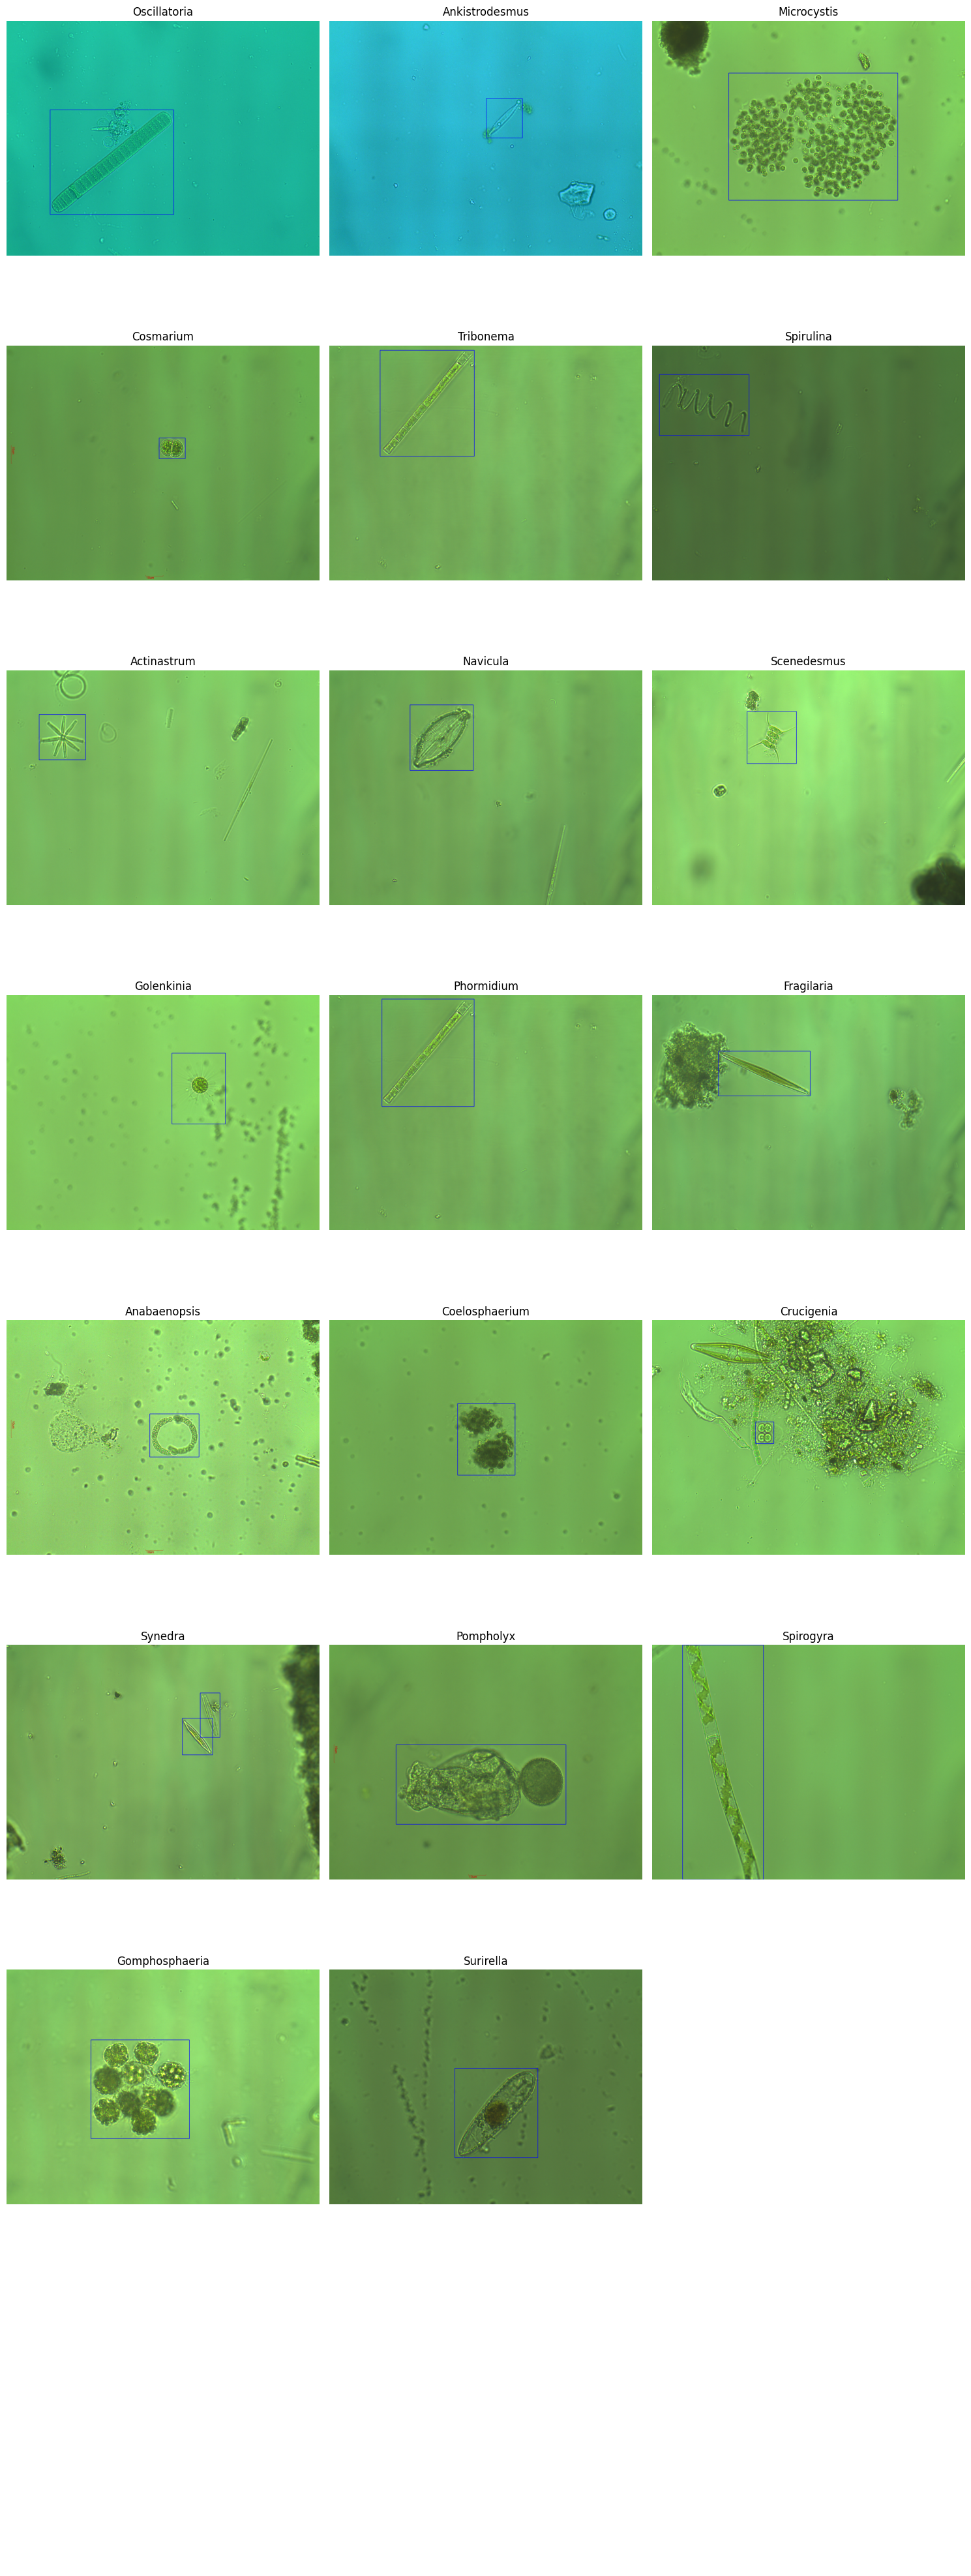

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import csv
import xml.etree.ElementTree as ET

def read_class_mapping(csv_file):
    class_mapping = {}
    with open(csv_file, mode='r') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip header
        for rows in reader:
            folder_name, class_name, harmful = rows
            class_mapping[folder_name] = class_name
    return class_mapping

def parse_xml(xml_file, target_class_code):
    """Membaca file XML dan mengembalikan daftar bounding box (xmin, ymin, xmax, ymax) hanya untuk kelas yang diinginkan."""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        class_code = obj.find('name').text  # Kode kelas dari XML (contoh: G001)
        if class_code == target_class_code:  # Filter berdasarkan kode kelas target
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append((xmin, ymin, xmax, ymax))
    return boxes

# Path ke file CSV dan direktori gambar dan XML
csv_file = '../class_mapping (1).csv'
image_dir = '../EMDS7'
xml_dir = '../EMDS7xml'

# Membaca file CSV dan membuat dictionary untuk mapping
class_mapping = read_class_mapping(csv_file)

# Daftar kelas yang diinginkan
desired_classes = [
    "Oscillatoria", "Ankistrodesmus", "Microcystis", "Cosmarium", "Tribonema", 
    "Spirulina", "Actinastrum", "Navicula", "Scenedesmus", "Golenkinia", 
    "Phormidium", "Fragilaria", "Anabaenopsis", "Coelosphaerium", "Crucigenia", 
    "Synedra", "Pompholyx", "Spirogyra", "Gomphosphaeria", "Surirella"
]

# Filter gambar berdasarkan kelas yang diinginkan (1 sampel per kelas)
filtered_images = {}
titles = []

for image_file in os.listdir(image_dir):
    if image_file.endswith('.png'):
        folder_name = image_file.split('-')[1]
        class_name = class_mapping.get(folder_name, 'Unknown')
        
        # Pastikan hanya menyimpan satu sampel per kelas yang diinginkan
        if class_name in desired_classes and class_name not in filtered_images:
            image_path = os.path.join(image_dir, image_file)
            xml_path = os.path.join(xml_dir, image_file.replace('.png', '.xml'))
            
            # Dapatkan kode kelas yang sesuai (contoh: G001) untuk digunakan sebagai target
            target_class_code = list(class_mapping.keys())[list(class_mapping.values()).index(class_name)]
            
            # Baca gambar dan bounding box dari XML hanya untuk kelas target
            image = cv2.imread(image_path)
            if os.path.exists(xml_path):
                boxes = parse_xml(xml_path, target_class_code)  # Pass kode kelas target (contoh: G001)
                # Gambar bounding box pada gambar
                for (xmin, ymin, xmax, ymax) in boxes:
                    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Biru untuk bounding box
            
            filtered_images[class_name] = image
            titles.append(class_name)

# Menampilkan satu gambar dengan bounding box untuk setiap kelas yang diinginkan
num_classes = len(filtered_images)
cols = 3
rows = (num_classes // cols) + (num_classes % cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, class_name in enumerate(filtered_images):
    axes[i].imshow(cv2.cvtColor(filtered_images[class_name], cv2.COLOR_BGR2RGB))
    axes[i].set_title(class_name)
    axes[i].axis('off')

# Matikan sisa subplot jika jumlah kelas tidak memenuhi semua subplot
for i in range(num_classes, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

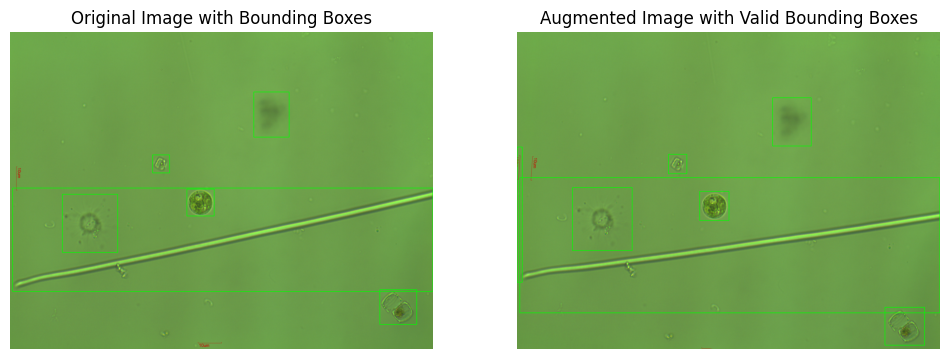

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import albumentations as A
import cv2
import xml.etree.ElementTree as ET

# Path ke direktori gambar dan XML
image_dir = '../EMDS7'
xml_dir = '../EMDS7xml'

# Pilih gambar secara acak dari direktori
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
random_image_file = random.choice(image_files)
image_path = os.path.join(image_dir, random_image_file)
xml_path = os.path.join(xml_dir, random_image_file.replace('.png', '.xml'))

# Fungsi untuk membaca bounding box dari XML file
def parse_bounding_boxes(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax - xmin, ymax - ymin])
    return boxes

# Fungsi untuk memeriksa distribusi warna dalam bounding box
def color_distribution_check(image, bbox, color_threshold=20):
    """Memeriksa apakah distribusi warna dalam BB bervariasi."""
    x_min, y_min, width, height = map(int, bbox)
    roi = image[y_min:y_min + height, x_min:x_min + width]
    
    # Hitung standar deviasi intensitas warna
    std_intensity = roi.std()
    
    # Jika variasi warna (standar deviasi) rendah, berarti mungkin hanya latar belakang
    return std_intensity > color_threshold

# Baca gambar dan bounding boxes
img = io.imread(image_path)
boxes = parse_bounding_boxes(xml_path)

# Definisikan augmentasi menggunakan Albumentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
], bbox_params=A.BboxParams(format='coco', label_fields=[]))

# Terapkan augmentasi pada gambar dan bounding box
transformed = transform(image=img, bboxes=boxes)
augmented_img = transformed['image']
augmented_bboxes = transformed['bboxes']

# Filter bounding box yang valid berdasarkan distribusi warna dan ukuran minimal
min_bbox_area = 20  # Batasan minimal luas BB
valid_bboxes = [
    bbox for bbox in augmented_bboxes 
    if color_distribution_check(augmented_img, bbox) and bbox[2] * bbox[3] > min_bbox_area
]

# Tampilkan hasil augmentasi dengan bounding boxes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gambar asli dengan bounding box
for box in boxes:
    x_min, y_min, width, height = box
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_min + width), int(y_min + height)), (0, 255, 0), 2)
ax1.imshow(img)
ax1.set_title('Original Image with Bounding Boxes')
ax1.axis('off')

# Gambar hasil augmentasi dengan bounding box valid
for box in valid_bboxes:
    x_min, y_min, width, height = box
    cv2.rectangle(augmented_img, (int(x_min), int(y_min)), (int(x_min + width), int(y_min + height)), (0, 255, 0), 2)
ax2.imshow(augmented_img)
ax2.set_title('Augmented Image with Valid Bounding Boxes')
ax2.axis('off')

plt.show()


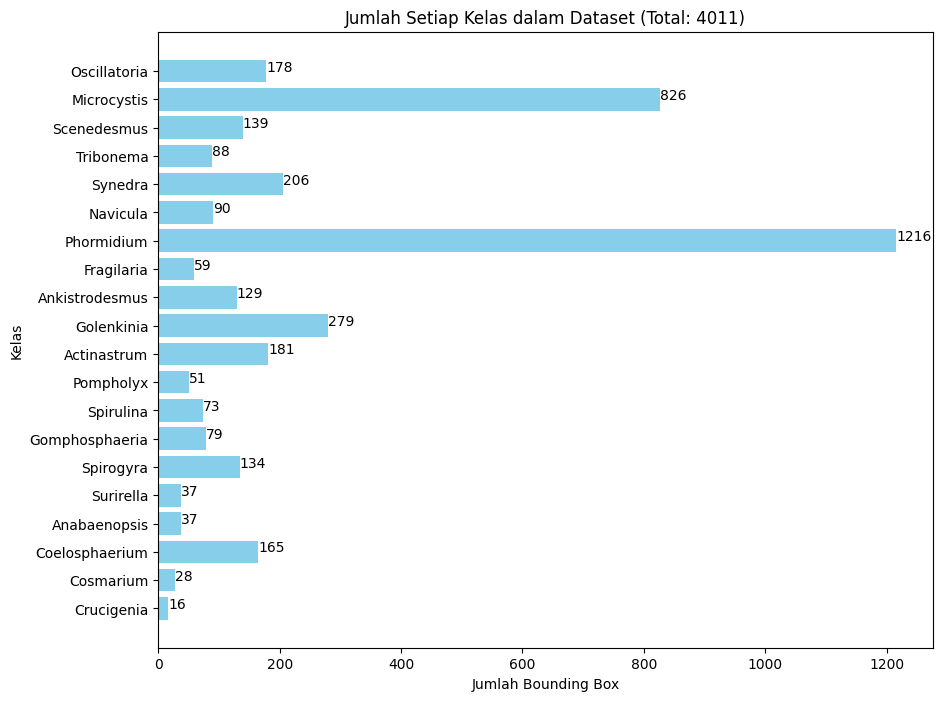

Jumlah total bounding box di seluruh kelas: 4011


In [7]:
import os
import cv2
import matplotlib.pyplot as plt
import csv
import xml.etree.ElementTree as ET
from collections import Counter

def read_class_mapping(csv_file):
    class_mapping = {}
    with open(csv_file, mode='r') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip header
        for rows in reader:
            folder_name, class_name, harmful = rows
            class_mapping[folder_name] = class_name
    return class_mapping

def parse_xml(xml_file):
    """Membaca file XML dan mengembalikan kode kelas dan daftar bounding box (xmin, ymin, xmax, ymax) untuk setiap objek."""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        class_code = obj.find('name').text  # Kode kelas dari XML (contoh: G001)
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append((class_code, xmin, ymin, xmax, ymax))
    return boxes

# Path ke file CSV dan direktori gambar dan XML
csv_file = '../class_mapping (1).csv'
image_dir = '../EMDS7'
xml_dir = '../EMDS7xml'

# Membaca file CSV dan membuat dictionary untuk mapping
class_mapping = read_class_mapping(csv_file)

# Inisialisasi counter untuk menyimpan jumlah setiap kelas di seluruh dataset
class_counts = Counter()

# Loop melalui semua file XML untuk menghitung jumlah bounding box per kelas
for xml_file in os.listdir(xml_dir):
    if xml_file.endswith('.xml'):
        xml_path = os.path.join(xml_dir, xml_file)
        boxes = parse_xml(xml_path)
        
        # Tambahkan jumlah bounding box untuk setiap kelas
        for class_code, xmin, ymin, xmax, ymax in boxes:
            class_name = class_mapping.get(class_code, 'Unknown')
            if class_name in desired_classes:
                class_counts[class_name] += 1

# Hitung total jumlah bounding box di seluruh kelas
total_boxes = sum(class_counts.values())

# Menampilkan hasil dengan bar plot
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 8))
plt.barh(classes, counts, color='skyblue')
plt.xlabel('Jumlah Bounding Box')
plt.ylabel('Kelas')
plt.title(f'Jumlah Setiap Kelas dalam Dataset (Total: {total_boxes})')
plt.gca().invert_yaxis()  # Membuat kelas dengan jumlah tertinggi di atas

# Tampilkan jumlah total di dalam plot
for index, value in enumerate(counts):
    plt.text(value, index, str(value))  # Menambahkan teks jumlah di samping setiap bar

plt.show()

# Menampilkan jumlah total bounding box di seluruh kelas di terminal
print(f"Jumlah total bounding box di seluruh kelas: {total_boxes}")

Diketahui distribusi kelas mayoritas memiliki angka yang sedikit, dan ada kelas yang memiliki distribusi yang banyak tetap terprediksi sebagai background

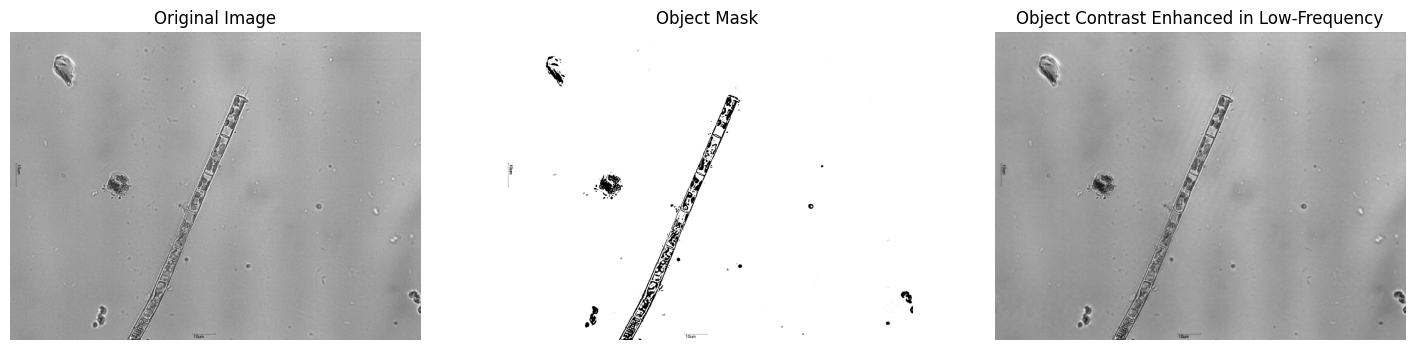

In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# Path ke direktori gambar
image_dir = 'D:\KULIAH\SEMESTER 5\RSBP\Bacteri\Detection-of-bacteria-in-water-using-Yolo-images\Detect\Detection-of-bacteria-in-water-using-Yolo-images\EMDS7'

# Pilih gambar secara acak dari direktori
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
random_image_file = random.choice(image_files)
image_path = os.path.join(image_dir, random_image_file)

# Baca gambar dan konversi ke grayscale
img = io.imread(image_path)
img_gray = color.rgb2gray(img)

# Buat mask objek dengan thresholding untuk memisahkan objek dari background
threshold = filters.threshold_otsu(img_gray)
object_mask = img_gray > threshold

# Fourier Transform untuk mendapatkan representasi frekuensi gambar
f_transform = fft2(img_gray)
f_transform_shifted = fftshift(f_transform)

# Buat mask untuk low-pass filter di domain frekuensi
rows, cols = img_gray.shape
crow, ccol = rows // 2, cols // 2  # Pusat frekuensi
low_pass_mask = np.zeros((rows, cols), np.uint8)
radius = 50  # Radius mask (frekuensi rendah)
low_pass_mask[crow-radius:crow+radius, ccol-radius:ccol+radius] = 1

# Gabungkan mask objek dengan mask frekuensi rendah di domain frekuensi
combined_mask = low_pass_mask * object_mask

# Terapkan mask gabungan pada transformasi Fourier
f_object_low_pass = f_transform_shifted * combined_mask

# Tingkatkan kontras pada komponen frekuensi rendah dari objek
alpha = 1.5  # Faktor peningkatan kontras
f_object_low_pass *= alpha

# Ganti komponen frekuensi tinggi dengan nilai aslinya untuk menjaga detail frekuensi tinggi
f_high_pass = f_transform_shifted * (1 - combined_mask)
f_result = f_object_low_pass + f_high_pass

# Inverse Fourier Transform untuk kembali ke domain spasial
f_ishift = ifftshift(f_result)
img_object_contrast_enhanced = ifft2(f_ishift)
img_object_contrast_enhanced = np.abs(img_object_contrast_enhanced)

# Plot hasil original, mask objek, dan gambar hasil peningkatan kontras
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Gambar asli
ax1.imshow(img_gray, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.axis('off')

# Mask objek
ax2.imshow(object_mask, cmap=plt.cm.gray)
ax2.set_title('Object Mask')
ax2.axis('off')

# Gambar hasil peningkatan kontras pada objek
ax3.imshow(img_object_contrast_enhanced, cmap=plt.cm.gray)
ax3.set_title('Object Contrast Enhanced in Low-Frequency')
ax3.axis('off')

plt.show()
